# Seminar: Starter Notebook
This notebook helps you quickly use your DataLoading (and optionally DataGraphing) classes in Jupyter.

👉 Flow: Install → Paths → config.py → (optional) Credentials → Loader demos

## 0. inital settings

In [1]:
%pip install -q pandas numpy plotly kaleido yfinance fredapi ecbdata requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Notebook is located at <PROJECT_ROOT>/notebooks/
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve().parent        # one level up from /notebooks
SRC_ROOT = PROJECT_ROOT / "src"                   # parent of 'seminar_code'
sys.path.insert(0, str(SRC_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_ROOT:", SRC_ROOT, "exists:", SRC_ROOT.exists())


PROJECT_ROOT: /Users/Robert_Hennings/Uni/Master/Seminar
SRC_ROOT: /Users/Robert_Hennings/Uni/Master/Seminar/src exists: True


In [ ]:
# --- one-time import (per kernel) ---
from seminar_code.data_loading.data_loader import DataLoading
from seminar_code.data_graphing.data_grapher import DataGraphing  # optional

dl = DataLoading() # <- for some APIs there is an API key required, the class expects a credential.json file somewhere with a key value mapping: {FRED_API: "some key"}, the ides to reference a central credentials file somewhere is to not accidently commit and push security tokens
dg = DataGraphing()
print("Instances ready.")

Instances ready.


In [60]:
# --- hot reload after you edited the source files ---
import importlib

import seminar_code.data_loading.data_loader as dl_mod
import seminar_code.data_graphing.data_grapher as dg_mod  # optional

importlib.reload(dl_mod)
importlib.reload(dg_mod)  # optional

from seminar_code.data_loading.data_loader import DataLoading
from seminar_code.data_graphing.data_grapher import DataGraphing  # optional

dl = DataLoading()
dg = DataGraphing()
print("Modules reloaded and instances created.")


Modules reloaded and instances created.


In [46]:
import io, requests
import pandas as pd
import json
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp

from plotly.subplots import make_subplots
from fredapi import Fred
from pathlib import Path
from seminar_code.data_loading.data_loader import DataLoading

## 2. load data

In [5]:
# Set dates
START_DATE = pd.Timestamp("2000-01-01")
END_DATE = pd.Timestamp("2025-01-01")

### 2.1. FRED

In [ ]:
# --- FRED only: API key -> (ensure) loader -> fetch series ---
FRED_KEY = "4d07b674a78d08a1f75abfdd9a936bc8"

# write/update secrets/credentials.json next to your project (one level above /notebooks)
PROJECT_ROOT = Path.cwd().resolve().parent   # assumes this notebook is in /notebooks
SECRETS_DIR  = PROJECT_ROOT / "secrets"
SECRETS_DIR.mkdir(parents=True, exist_ok=True)
CRED_FILE = SECRETS_DIR / "credentials.json"
CRED_FILE.write_text(json.dumps({"FRED_API": FRED_KEY, "US_Bureau_of_Labor_Statistics": ""}, indent=2),
                     encoding="utf-8")

92

In [7]:
# Quck and dirty way to set the API key in the DataLoading instance
FRED_KEY = "4d07b674a78d08a1f75abfdd9a936bc8"
from fredapi import Fred
dl = DataLoading()
dl.fred = Fred(api_key=FRED_KEY)

In [37]:
# fetch FRED series
fred_map = {"WTI": "DCOILWTICO", "Brent": "DCOILBRENTEU"} #, "FedFundsRate": "DFF"}
series_dict, meta_dict, lowest = dl.get_fred_data(
    series_dict_mapping=fred_map,
    start_date=START_DATE,
    end_date=END_DATE
)

fred_df = pd.DataFrame(series_dict).astype(float)
fred_df.fillna(method="ffill", inplace=True)

2025-10-09 23:13:55,567 - INFO - Fetching data for variable WTI with series id: (DCOILWTICO) for start date: 2000-01-01 00:00:00 and end date: 2025-01-01 00:00:00
2025-10-09 23:13:56,701 - INFO - Actual start date for loaded data variable: WTI with series id: (DCOILWTICO): 2000-01-03 00:00:00 instead of 2000-01-01 00:00:00
2025-10-09 23:13:56,702 - INFO - Inferred frequency for WTI is B
2025-10-09 23:13:56,703 - INFO - Fetching data for variable Brent with series id: (DCOILBRENTEU) for start date: 2000-01-01 00:00:00 and end date: 2025-01-01 00:00:00
2025-10-09 23:13:57,712 - INFO - Actual start date for loaded data variable: Brent with series id: (DCOILBRENTEU): 2000-01-03 00:00:00 instead of 2000-01-01 00:00:00
2025-10-09 23:13:57,714 - INFO - Inferred frequency for Brent is B
2025-10-09 23:13:57,715 - INFO - Lowest (slowest) frequency: D


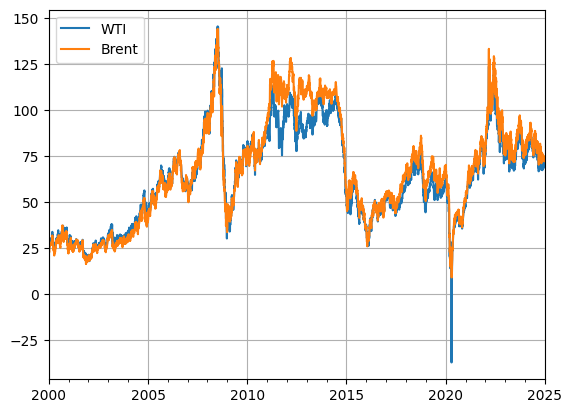

In [39]:
# Simple plot
fred_df['WTI'].plot(label="WTI")
fred_df['Brent'].plot(label="Brent")
# fred_df['FedFundsRate'].plot(label="FedFundsRate")

plt.legend()
plt.grid()
plt.show()

### 2.2. BIS - Exchange rate basket

In [ ]:
from seminar_code.data_loading import config as cfg
print(dir(cfg))
# Here you have the mapping dict of all the exchange rate types
print(cfg.BIS_EXCHANGE_RATE_MAPPING_DICT)
BIS_EXCHANGE_RATE_MAPPING_DICT = cfg.BIS_EXCHANGE_RATE_MAPPING_DICT

country_keys_mapping = {
    "US": "United States" # <- pass here the country abbreviations, pass as many as you want
}
exchange_rate_type_list = [
    "Real effective exchange rate - monthly - broad basket", # <- pass the full name here so we can immediately see what rate is used
    "Real effective exchange rate - monthly - narrow basket" # <- pass the full name here so we can immediately see what rate is used
]
bis_data_df = dl.get_bis_exchange_rate_data(
    country_keys_mapping=country_keys_mapping,
    exchange_rate_type_list=exchange_rate_type_list,
)
bis_data_df

2025-10-08 21:36:54,788 - INFO - Fetching data from URL: https://stats.bis.org/api/v2/data/dataflow/BIS/WS_EER/1.0/M.R.B.US?format=csv


['BIS_DATA_BASE_URL', 'BIS_EXCHANGE_RATE_MAPPING_DICT', 'ERROR_CODES_DICT', 'PARAMS_MAPPING_DICT', 'REQUEST_TIMEOUT', 'SAVE_PATH', 'STORAGE_OPTIONS_DICT', 'SUCCESS_CODES_DICT', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']
{'Real effective exchange rate - monthly - broad basket': 'M.R.B.', 'Real effective exchange rate - monthly - narrow basket': 'M.R.N.', 'Nominal effective exchange rate - monthly - broad basket': 'M.R.B.', 'Nominal effective exchange rate - monthly - narrow basket': 'M.R.N.', 'Nominal effective exchange rate - daily - narrow basket': 'D.N.N.', 'Nominal effective exchange rate - daily - broad basket': 'D.N.B.'}


2025-10-08 21:36:55,512 - INFO - Fetching data from URL: https://stats.bis.org/api/v2/data/dataflow/BIS/WS_EER/1.0/M.R.N.US?format=csv
/Users/Robert_Hennings/Uni/Master/Seminar/src/seminar_code/data_loading/data_loader.py:507: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



,US_Real effective exchange rate - monthly - broad basket,US_Real effective exchange rate - monthly - narrow basket
TIME_PERIOD,,
1964-01-01,NaN,115.96
1964-02-01,NaN,115.58
1964-03-01,NaN,115.42
1964-04-01,NaN,114.79
1964-05-01,NaN,118.00
...,...,...
2025-04-01,111.39,106.79
2025-05-01,109.90,105.16
2025-06-01,108.71,103.63


REF_AREA         US
TIME_PERIOD        
2025-09-26   104.07
2025-09-27      NaN
2025-09-28      NaN
2025-09-29   103.66
2025-09-30   103.58


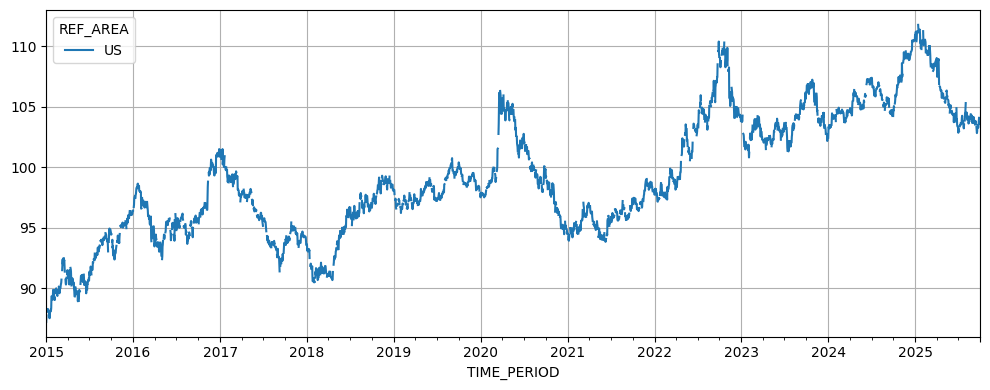

In [67]:
# call BIS API directly (no wrapper available yet)
# see https://www.bis.org/statistics/full_data_sets.htm?m=6%
BASE = "https://stats.bis.org/api/v1/data"
DATASET = "WS_EER"                 # <-- ohne _D !
KEY = "D.N.B.US"                   # D=daily, N=nominal, B=broad, US=US dollar

url = f"{BASE}/{DATASET}/{KEY}"
params = {"format": "csv", "startPeriod": "2015"}  # optional: start/end
r = requests.get(url, params=params, timeout=30)
r.raise_for_status()

# set up DataFrame
bis_df = pd.read_csv(io.StringIO(r.text))
wide = bis_df.pivot(index="TIME_PERIOD", columns="REF_AREA", values="OBS_VALUE")
wide.index = pd.to_datetime(wide.index)
wide.rename(columns={"DE": "Germany NEER (daily, broad)"}, inplace=True)

print(wide.tail())
wide.plot(figsize=(10,4)); plt.grid(True); plt.tight_layout(); plt.show()


### 2.3. yahoo Finance

In [69]:
# Yahoo Finance data
yf_df = dl.get_yahoo_data(
    ticker=["CL=F","NG=F"],                # WTI & NatGas futures
    start_date=START_DATE,
    end_date=END_DATE,
    auto_adjust=False,
    interval="1d"
)

[*********************100%***********************]  2 of 2 completed

FUNCTION: get_yahoo_data


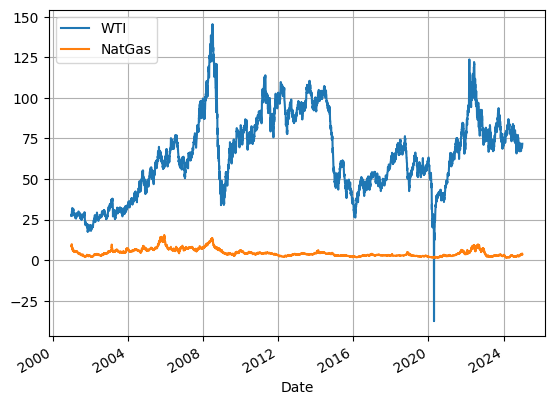

In [70]:
# Simple plot
yf_df['Close']['CL=F'].plot(label="WTI")
yf_df['Close']['NG=F'].plot(label="NatGas")

plt.legend()
plt.grid()
plt.show()

## 2. Markov switch application

Source: https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html?utm_source=chatgpt.com
- Didn't find this feature in the scikit learn bib, prob. best to condcut our econometric analysis with stats.
- ...

### 2.1. (First) dummy example

In [ ]:
import numpy as np
import statsmodels.api as sm

In [ ]:
# Set time index
fred_df.index = pd.to_datetime(fred_df.index)

# Make data stationary
fred_stat_df = np.log(fred_df).pct_change().dropna()

# Define dummy data
wti_data = fred_stat_df['WTI'].loc['2020':]

In [ ]:
# Standardize (helps optimization - otherwise no convergence)
def standardize(series):
    return (series - series.mean()) / series.std()

wti_data = standardize(wti_data)

In [ ]:
# Augmented Dickey-Fuller test
adf_wti = sm.tsa.stattools.adfuller(wti_data)

print("ADF Statistic (WTI):", adf_wti[0], "p-value:", adf_wti[1], "critical_values:", adf_wti[4])

# The data is stationary if the ADF statistic is less than the critical value and the p-value is less than 0.05. 
# So we are good to go for Markov Switching/econmetric modeling..

ADF Statistic (WTI): -8.257339786601388 p-value: 5.19431037294698e-13 critical_values: {'1%': -3.4339840952648695, '5%': -2.8631452508003057, '10%': -2.567624583142913}


- Data is stationary if the ADF statistic is less than the critical value and the p-value is less than 0.05. 
- So we are good to go for Markov Switching/econmetric modeling..

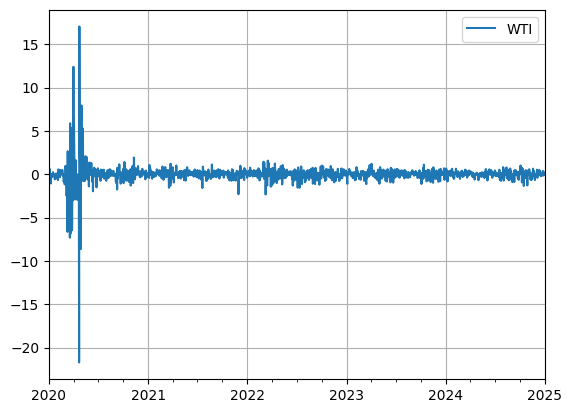

In [200]:
# Visual stationarity check
wti_data.plot(label="WTI")

plt.legend()
plt.grid()
plt.show()

---> Negative values periode might be problematic for log-returns and the model estimation. Will be filtered out in a first step.

In [196]:
# MS model test
mod = sm.tsa.MarkovRegression(
    wti_data,
    k_regimes=2, trend='n', switching_variance=True, freq='D'
    )

wti_res = mod.fit()
print(wti_res.summary())

                        Markov Switching Model Results                        
Dep. Variable:                    WTI   No. Observations:                 1828
Model:               MarkovRegression   Log Likelihood               -1071.241
Date:                 Di, 07 Okt 2025   AIC                           2150.482
Time:                        18:53:54   BIC                           2172.526
Sample:                    01-01-2020   HQIC                          2158.613
                         - 01-01-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1187      0.006     20.394      0.000       0.107       0.130
                             Regime 1 parameters    

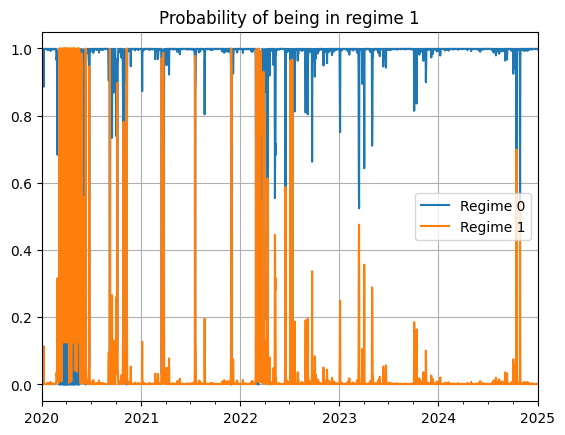

In [198]:
# See probability of being in regime 0 or 1
probs = wti_res.smoothed_marginal_probabilities
probs[0].plot(title="Probability of being in regime 0", label="Regime 0")
probs[1].plot(title="Probability of being in regime 1", label="Regime 1")

plt.legend()
plt.grid()
plt.show()

## 3. First Regression model -- US-FX basket by GAS, Oil, Fed Funds Rate
Idea: Set up a small regression model with:
1. Endogenous variable = NEER Index (narrow basket)
2. Exogenous variables = WTI, BENT, Fed Funds Rate

Method: 
1. Load and merge data to one df.
2. Transform prices to stationary data. --> "log(diff())*100" to get rate of change in percent --> better interpretation later on.
3. Test stationarity, visually and by ADF-test.


In [273]:
# Help functions --
def get_stationary_series(df, rates=None):
    """
    Convert a DataFrame of time series data into stationary series.
    - Preise/Indizes -> log-differenced * 100 (percent changes)
    - Rates (Zinsen) -> simple difference (absolute change)

    Parameters:
    df (pd.DataFrame): Input DataFrame with time series data.
    rates (list): List of column names that should be treated as rates.
                  If None, assumes no rates.

    Returns:
    pd.DataFrame: DataFrame with stationary series.
    """
    if rates is None:
        rates = []

    out = pd.DataFrame(index=df.index)

    for col in df.columns:
        if col in rates:
            out[col] = df[col].diff()
        else:
            out[col] = np.log(df[col]).diff() * 100

    return out.dropna()

def get_standardize(series):
    """
    Standardize a pandas Series.
    
    Parameters:
    series (pd.Series): Input Series to be standardized.
    
    Returns:
    pd.Series: Standardized Series.
    """
    return (series - series.mean()) / series.std()

In [ ]:
# Load NEER data from CSV (downloaded manually from BIS website)
load_csv_df = pd.read_csv("neer_basket_data_01012000.csv", sep=",", skiprows=1, header=1)

load_csv_df.set_index("TIME_PERIOD:Period", inplace=True)
load_csv_df.index = pd.to_datetime(load_csv_df.index)
load_csv_df.rename(columns={"OBS_VALUE:Value": "NEER_USD"}, inplace=True)

# Separate NEER series
neer_df = load_csv_df[["NEER_USD"]].copy()
neer_df.fillna(method="ffill", inplace=True)

In [266]:
# Join all data sources into one DataFrame
all_data = pd.concat([neer_df, fred_df], axis=1)
all_data.dropna(inplace=True)

In [ ]:
# Transform to stationary series
all_stat_df = get_stationary_series(all_data, rates=["FedFundsRate"])

c:\Users\josef\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

invalid value encountered in log



Check for stationarity

In [285]:
# Visual check for stationarity
fig = go.Figure()
for col in all_stat_df.columns:
    fig.add_trace(go.Scatter(x=all_stat_df.index, y=all_stat_df[col], mode='lines', name=col))
fig.update_layout(title="Visual Test for stationarity", xaxis_title="Date", yaxis_title="Value")
fig.show()

In [ ]:
# Check for stationarity - ADF test
for i in all_stat_df.columns:
    print(f"ADF test for {i}:")
    result = sm.tsa.stattools.adfuller(all_stat_df[i])
    print(f"  ADF Statistic: {result[0]}")
    print(f"  p-value: {result[1]}")
    for key, value in result[4].items():
        print(f"  Critical Value ({key}): {value}")
    print()

Simple econonometric model(s)

In [ ]:
# Simmple OLS regression model
y = all_stat_df['NEER_USD']
X = all_stat_df[['WTI', 'Brent', 'FedFundsRate']]
X = sm.add_constant(X)  # add constant term for intercept --> for interpretation of coefficients

ols_model = sm.OLS(y, X).fit()

ols_model.summary()

Results: 
- Overall R^2 very low: Only 2.2% of variance is explained by this model.
- Overall F-statistic is < p-value, so we have significance.
- Only significant variable here is **Oil** --> Evidence to dig deeper on that end + add evidence of oil importance for USD.
- Significance of Oil also cause co-interval belowe 0 for both bounds.

In [ ]:
y = all_stat_df['NEER_USD']

# Exogenous variables
X = all_stat_df[['WTI', 'Brent', 'FedFundsRate']]
X.index = y.index   # same index?
X = sm.add_constant(X)

# Markov Switching Model
ms_model = sm.tsa.MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    trend='n',
    switching_variance=False,
    freq='D'
)

ms_res = ms_model.fit()
print(ms_res.summary())

In [ ]:
probs = ms_res.smoothed_marginal_probabilities
probs_index = probs.index.to_timestamp()


# Output smoothed probabilities in subplots
fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=True,
                       subplot_titles=("Smoothed probability of Regime 0", 
                                       "Smoothed probability of Regime 1"))

# Regime 0
fig.add_trace(
    go.Scatter(x=probs_index, y=probs[0], mode='lines', name='Regime 0'),
    row=1, col=1
)

# Regime 1
fig.add_trace(
    go.Scatter(x=probs_index, y=probs[1], mode='lines', name='Regime 1'),
    row=2, col=1
)

fig.update_layout(
    height=600, width=900,
    title="Smoothed Marginal Probabilities of Regimes",
    xaxis_title="Date",
    yaxis_title="Probability"
)

fig.show()

Results:
- Models finds 2 regimes, but only this spec works. --> for more we get the problem of non-convergence.
- BUT clearly we can see the time-varying nature of things with changing mean here.

TRY: Only include Oil as external variable

In [ ]:
# New MS model
y = all_stat_df['NEER_USD']
X = all_stat_df[['WTI']]  # only oil as external variable
X.index = y.index   # same index?

ms_oil_model = sm.tsa.MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=3,
    trend='n',
    switching_variance=False,
    freq='D'
)

ms_oil_res = ms_oil_model.fit()
print(ms_oil_res.summary())

## 4. Only Focus on Oil and Gas
- Now we separation in pre-/ and post corona phases (model without corona phase 2020-2021)
- Include all previus methods

In [64]:
# Help functions --
def get_stationary_series(df, rates=None):
    """
    Convert a DataFrame of time series data into stationary series.
    - Preise/Indizes -> log-differenced * 100 (percent changes)
    - Rates (Zinsen) -> simple difference (absolute change)

    Parameters:
    df (pd.DataFrame): Input DataFrame with time series data.
    rates (list): List of column names that should be treated as rates.
                  If None, assumes no rates.

    Returns:
    pd.DataFrame: DataFrame with stationary series.
    """
    if rates is None:
        rates = []

    out = pd.DataFrame(index=df.index)

    for col in df.columns:
        if col in rates:
            out[col] = df[col].diff()
        else:
            out[col] = np.log(df[col]).diff() * 100

    return out.dropna()

def get_standardize(series):
    """
    Standardize a pandas Series.
    
    Parameters:
    series (pd.Series): Input Series to be standardized.
    
    Returns:
    pd.Series: Standardized Series.
    """
    return (series - series.mean()) / series.std()

In [40]:
# Load NEER data from CSV (downloaded manually from BIS website) --> replace with API call later
load_csv_df = pd.read_csv("neer_basket_data_01012000.csv", sep=",", skiprows=1, header=1)

load_csv_df.set_index("TIME_PERIOD:Period", inplace=True)
load_csv_df.index = pd.to_datetime(load_csv_df.index)
load_csv_df.rename(columns={"OBS_VALUE:Value": "NEER_USD"}, inplace=True)

# Separate NEER series
neer_df = load_csv_df[["NEER_USD"]].copy()
neer_df.fillna(method="ffill", inplace=True)

# Merge data
all_data = pd.concat([neer_df, fred_df], axis=1)
all_data.dropna(inplace=True)

In [41]:
# Kick out covid shock
pre_cov_df = all_data.loc[:"2020-03-01"]
post_cov_df = all_data.loc["2020-06-01":]

### 4.1. Visualization of data/Correlation

In [62]:
# See any correlation @all and differences pre vs. post covid?
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{"secondary_y": True}],
           [{"secondary_y": True}]],
    subplot_titles=("Pre-Covid (until 2020-03-01)", "Post-Covid (from 2020-06-01)")
)

fig.add_trace(go.Scatter(x=pre_cov_df.index,  y=pre_cov_df["WTI"],   mode="lines", name="WTI"),   row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=pre_cov_df.index,  y=pre_cov_df["Brent"], mode="lines", name="Brent"), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=pre_cov_df.index,  y=pre_cov_df["NEER_USD"], mode="lines", name="NEER_USD"), row=1, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=post_cov_df.index, y=post_cov_df["WTI"],   mode="lines", name="WTI"),   row=2, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=post_cov_df.index, y=post_cov_df["Brent"], mode="lines", name="Brent"), row=2, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=post_cov_df.index, y=post_cov_df["NEER_USD"], mode="lines", name="NEER_USD"), row=2, col=1, secondary_y=True)


fig.update_layout(title="WTI & Brent (left) vs. NEER_USD (right): Pre vs. Post Covid", height=800)
fig.show()


In [63]:
# Correlation matrix
pre_corr_matrix = pre_cov_df.corr()
post_corr_matrix = post_cov_df.corr()
print("Pre-Covid Correlation Matrix:\n", pre_corr_matrix)
print("\nPost-Covid Correlation Matrix:\n", post_corr_matrix)


Pre-Covid Correlation Matrix:
           NEER_USD       WTI     Brent
NEER_USD  1.000000 -0.870485 -0.852738
WTI      -0.870485  1.000000  0.981093
Brent    -0.852738  0.981093  1.000000

Post-Covid Correlation Matrix:
           NEER_USD       WTI     Brent
NEER_USD  1.000000  0.487881  0.505920
WTI       0.487881  1.000000  0.995354
Brent     0.505920  0.995354  1.000000


Results: 
- Pre corona visually rather negative correlation between FX and energy. Correlation also underline this finding.
- Post corona we have a positive co-movement, which is also evident by looking @ data.
- Is in line with ECB findings from 2024: https://www.ecb.europa.eu/press/economic-bulletin/focus/2024/html/ecb.ebbox202407_02~5ce155d504.en.html?utm_source=chatgpt.com + further shifted terms of trade according to BIS: https://www.bis.org/publ/work1083.htm?utm_source=chatgpt.com
- Now we want to further analyze these relationships and their (statistical) significance

### 4.2. Transform data into stationarity

In [65]:
pre_covid = get_stationary_series(pre_cov_df)
post_covid = get_stationary_series(post_cov_df)

Check stationarity

In [ ]:
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False, shared_yaxes=True,
    subplot_titles=("Pre-Covid", "Post-Covid")
)

for col in pre_covid.columns:
    # Pre
    fig.add_trace(
        go.Scatter(x=pre_covid.index, y=pre_covid[col], mode='lines',
                   name=col, legendgroup=col),
        row=1, col=1
    )
    # Post
    fig.add_trace(
        go.Scatter(x=post_covid.index, y=post_covid[col], mode='lines',
                   name=col, legendgroup=col, showlegend=False),
        row=2, col=1
    )

fig.update_layout(title="Visual Test for Stationarity: Pre vs Post Covid", height=800)
fig.show()


In [81]:
# ADF test
for i in pre_covid.columns:
    print(f"ADF test for {i}:")
    result = sm.tsa.stattools.adfuller(pre_covid[i])
    print(f"  ADF Statistic: {result[0]}")
    print(f"  p-value: {result[1]}")
    # for key, value in result[4].items():
    #     print(f"  Critical Value ({key}): {value}")
    print()
    
for i in post_covid.columns:
    print(f"ADF test for {i}:")
    result = sm.tsa.stattools.adfuller(post_covid[i])
    print(f"  ADF Statistic: {result[0]}")
    print(f"  p-value: {result[1]}")
    # for key, value in result[4].items():
    #     print(f"  Critical Value ({key}): {value}")
    print()


ADF test for NEER_USD:
  ADF Statistic: -20.00891164633653
  p-value: 0.0

ADF test for WTI:
  ADF Statistic: -27.29732155647588
  p-value: 0.0

ADF test for Brent:
  ADF Statistic: -71.7767569758876
  p-value: 0.0

ADF test for NEER_USD:
  ADF Statistic: -10.470487267536013
  p-value: 1.2881563169603332e-18

ADF test for WTI:
  ADF Statistic: -12.992930245812554
  p-value: 2.788070989085885e-24

ADF test for Brent:
  ADF Statistic: -16.09885901940514
  p-value: 5.15755686159348e-29



Results:
- Both ADF test and visual check are indicating a successful transformation.

### 4.3. OLS Regression

In [ ]:
# Pre covid OLS regression
y = pre_covid['NEER_USD']
X = pre_covid[['WTI', 'Brent']]
X = sm.add_constant(X)

pre_ols_model = sm.OLS(y, X).fit()

# Post covid OLS regression 
y = post_covid['NEER_USD']
X = post_covid[['WTI', 'Brent']]
X = sm.add_constant(X)

post_ols_model = sm.OLS(y, X).fit()

print("Pre-Covid OLS Regression Summary:")
print(pre_ols_model.summary())
print("\nPost-Covid OLS Regression Summary:")
print(post_ols_model.summary())

Pre-Covid OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:               NEER_USD   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     93.90
Date:                 Do, 09 Okt 2025   Prob (F-statistic):           8.51e-41
Time:                        23:58:46   Log-Likelihood:                -2678.5
No. Observations:                5258   AIC:                             5363.
Df Residuals:                    5255   BIC:                             5383.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0